# Montecarlo simulation
As we have stated before a really interesting feature of the hopfield model is that give us the possibility of mapping a neuron system into a spin glasses system. 

We can so employ technics developed to study physical systems to use the hopfield model in a optimized way. We will see in the following that we can pass from an algorithm that takes $O(N^2t)$ operation, with $N$ size of the system and $t$ the number of iteration of the update rule, to an algorithm that takes $O(Nt)$ operation for the Mean Field case, or even less in the Non-MF case.

Montecarlo simulations are simulation that uses pseudorandom number to simulate a physical system. For this particular task we aim at finding the ground state of a spin system using as update rule the metropolis rule. 

Given the system energy $\mathcal{H}$ we randomly flip a spin of the system and we compute the difference in energy $\Delta\mathcal{H}=\mathcal{H}_{f}-\mathcal{H}_{i}$. Then we accept the updated system with the following probability:
$$
\begin{equation}
p_{acc}= \min\left( 1, e^{-\beta\Delta\mathcal{H}} \right)
\end{equation}
$$
where $\beta=(K_{b}T)^{-1}$ is the inverse of the size of the system. In this way if the energy is decreasing we update the system with probability 1, and if it is greater with a probability proportional to the increase in energy.

From the theory we know that the critical temperature, the highest temperature at which the system is trapped in the minima, is $T=1/K_b$.

In this section we will so look at:
- The stability of the Montecarlo methods;
- The improvement in the time implementation of Montecarlo;
- The dependance of the algorithm's performances w.r.t. the type of noise;
- The dependance of the algorithm's performances w.r.t. the number of neighbors for the NON-MF version;

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp
from copy import deepcopy

In [3]:
# Parameters
L = 10  # Lenght of the edge of the image
N = L**2 # Number of spins 
p = 10 # Number of patterns
MF = 0 # Use or not the Mean Field strategy: if MF=1 uses MF, if MF = 0 only spins at
# a distance R interacts
R = 3 # The 3-nearest neighbor interacts
np.random.seed(1234) # Seed to make the random process reproducible

In [4]:
# Function that are in previous notebook
def random_patterns(N,p):
    xi = np.random.randint(0,2,N*p).reshape(p,N) # Each line is a pattern
    xi[xi==0]=-1
    return xi

def MF_coupling(xi,N):
    J = 1/N * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(N) for j in range(N) ] )
    J = J.reshape(N,N)        
    for i in range(len(J)):
        J[i,i] = 0
    return J

def R_coupling(xi,N,R):
    J = MF_coupling(xi,N)
    for i in range( J.shape[0] ):
        J_temp = J[i].reshape(L,L)
        for j in range(L):
            y = (i%L -j)**2 # Look at indexes should be ok -1
            for k in range(L):
                if np.sqrt( (i//L - k)**2 + y ) > R: J_temp[j,k] = 0
        J[i] = J_temp.reshape(1,N)
    return J

def update(sys1):
    sys = deepcopy(sys1)
    N = len(sys)
    temp = np.zeros(N) 
    for i in range(N):
        for j in range(N): #Maybe it is possible to set the cycle on J[i][j]!=0 only
            temp[i] +=  J[i][j]*sys[j]
        if temp[i] == 0: temp[i] = 2*np.random.randint(0,2)-1
    sys = np.sign(temp)
    return np.sign(sys)

def deterministic_hopfield(sys1, t):
    sys = deepcopy(sys1)
    for i in range(t):
        sys = update(sys)
    return sys

def error_im(xi_idx, sys):
    wrong_pixels = (np.abs( sys-xi_idx )/2).sum()
    return wrong_pixels/len(sys)

def assign_pattern(xi,sys):
    errors = [ error_im(i,sys) for i in xi ]
    correct = np.argmin(errors)
    return correct

def total_error(xi,t):
    errors = []
    prediction = []
    for mu in range(len(xi)):
        sys = deterministic_hopfield(xi[mu],t)
        errors.append( error_im(xi[mu],sys) )
        if assign_pattern(xi,sys)==mu:
            prediction.append( 1 )
        else: prediction.append( 0 )
    errors = (np.array(errors)).mean()
    prediction = np.array(prediction).sum()/len(xi)
    return errors, prediction

def corrupt_uniform(sys, q): # q probability to flip the pixel
    sys_temp = deepcopy(sys)
    N = sys.shape[0]
    for i in range(N):
        r = np.random.rand()
        if r < q:
            sys_temp[i] *= -1
    return sys_temp

def plot(x, y, sys): # x-> Original, y-> Corrupted, sys-> Recovered
    fig, ax = plt.subplots(1,3, figsize=(15,8))
    ax[0].set_title('Original pattern')
    ax[0].imshow(x.reshape(L,L),cmap='Greys')
    ax[1].set_title('Corrupted pattern')
    ax[1].imshow(y.reshape(L,L),cmap='Greys')
    ax[2].set_title('Recovered pattern')
    ax[2].imshow(sys.reshape(L,L),cmap='Greys')
    plt.show()
    
def algorithm(xi, idx, yi):
    sys = deterministic_hopfield(yi,30)

    wrong_pixels = error_im(xi[idx],sys)
    assigned_pattern = assign_pattern(xi,sys)
    
    return wrong_pixels, assigned_pattern, sys

def corrupt_norm(sys, k, h):
    sys_temp = deepcopy(sys)
    sys_temp = sys_temp.reshape(L,L)
    N = sys.shape[0]
    for i in range(L):
        for j in range(L):
            g = gaus(k, L/5, h, i, j)
            r = np.random.rand()
            if r < g:
                sys_temp[i][j] *= -1
    return (sys_temp.reshape(1,N))[0]

def gaus(mu, sigma, h, x, y):
    h = np.sqrt(h)
    g_x = np.exp(-( (x-mu[0])**2 / ( 2.0 * sigma**2 ) ) )*h#/np.sqrt(2*np.pi*sigma**2)
    g_y = np.exp(-( (y-mu[1])**2 / ( 2.0 * sigma**2 ) ) )*h#/np.sqrt(2*np.pi*sigma**2)
    g = g_y * g_x
    return g

In [5]:
def H(J,sys):
    N = sys.shape[0]
    energy = 0
    for i in range(N):
        for j in range(i):
            energy -= J[i][j]*sys[i]*sys[j]
    return energy

# Mean Field version of dH
def dH(J, sys, k): # k is the index of the spin flipped
    N = sys.shape[0]
    dh = 0
    for i in range(N):
        dh += sys[i]*J[k][i]
    dh *= 2*sys[k]
    return dh

def metropolis(J, sys1, k, B): # B = 1/kbT temperature of the system
    sys = deepcopy(sys1)
    dh = dH(J, sys, k)
    r = np.random.rand() # random variable between (0,1)
    if r < np.exp( -B*dh ):
        sys[k] = -sys[k]
    return sys
    
def montecarlo(J, sys1, B, t ): # t number of iteration of the montecarlo
    sys = deepcopy(sys1)
    N = sys.shape[0]
    for i in range(t):
        k = np.random.randint(0,N)
        sys = metropolis(J, sys, k, B)
    return sys

## Mean field montecarlo

In [5]:
xi = random_patterns(N,p)
J = MF_coupling(xi,N)

### Stability

The error of the algorithm is 0.000000
The algorithm recognised the pattern 7 and the correct pattern is 7


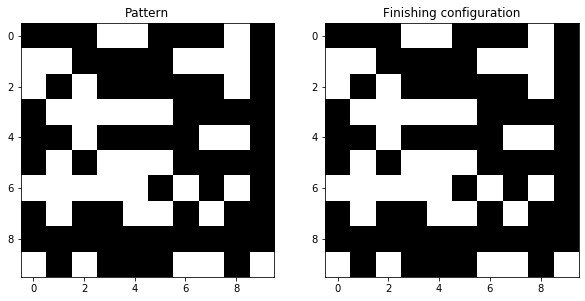

In [6]:
idx = np.random.randint(10)

sys = montecarlo(J,xi[idx], 10, 1000)
wrong_pixels = error_im(xi[idx],sys)
assigned_pattern = assign_pattern(xi,sys)


fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].set_title('Pattern')
ax[0].imshow(xi[idx].reshape(L,L), cmap='Greys')
ax[1].set_title('Finishing configuration')
ax[1].imshow(sys.reshape(L,L), cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

Stability for different temperature, $\beta=[0,1,10,25,50,100]$ with $t=1000$ and $L=10$ fixed. <br>
Each point $100$ iteration.

In [7]:
beta = [0, 1, 10, 25, 50, 100]
err_beta_mean = []
err_beta_std = []
success = []
for b in beta:
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        sys = montecarlo(J,xi[idx], b, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_beta_mean.append( errors.mean() )
    err_beta_std.append( errors.std() )
    success.append(correct)

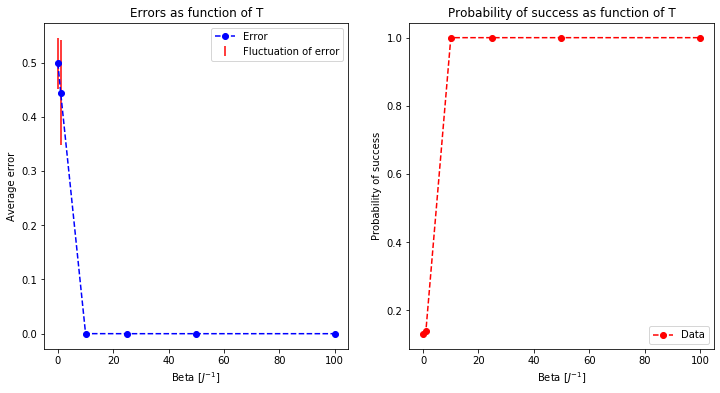

In [8]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of T')
ax[0].set_xlabel('Beta [$J^{-1}$]')
ax[0].set_ylabel('Average error')
ax[0].plot(beta, err_beta_mean, '--bo', label='Error')
ax[0].errorbar(beta,err_beta_mean, yerr=err_beta_std,ecolor='red', label='Fluctuation of error',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of T')
ax[1].set_xlabel('Beta [$J^{-1}$]')
ax[1].set_ylabel('Probability of success')
ax[1].plot(beta, success, '--ro', label='Data')
ax[1].legend()

We can see how an high $\beta$ lends to an high probability of success, and a $\beta<10$ lends to totally unacceptable results.

Even if the results with $\beta>25$ seems the better results we have to think on the functioning of the algorithm: with very high beta the probability of flipping a "wrong" spin is $\sim0$ and, starting from a minima, it probably means that it does not flip a spin at all. So, for the following analisys we will use $\beta=10$.

Stability w.r.t number of iterations $t=[10,25,50,100,200,500,750,1000,1250,1500,1750,2000]$ with $\beta=[10,25]$ and $L=10$ fixed. Each point is obtained with 100 run of the algorithm.

In [9]:
# Beta = 10
iterations=[10,25,50,100,200,500,750,1000,1250,1500,1750,2000]
err_t_mean = []
err_t_std = []
success_t = []
for t in iterations:
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        sys = montecarlo(J,xi[idx], 10, t)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_t_mean.append( errors.mean() )
    err_t_std.append( errors.std() )
    success_t.append(correct)

In [ ]:
# beta = 25
err_t1_mean = []
err_t1_std = []
success_t1 = []
for t in iterations:
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        sys = montecarlo(J,xi[idx], 25, t)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_t1_mean.append( errors.mean() )
    err_t1_std.append( errors.std() )
    success_t1.append(correct)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of iterations')
ax[0].set_xlabel('Number of iteration t')
ax[0].set_ylabel('Average error')
ax[0].plot(iterations, err_t_mean, '--bo', label='Error with beta=10')
ax[0].errorbar(iterations,err_t_mean, yerr=err_t_std,ecolor='blue',fmt='none')
ax[0].plot(iterations, err_t1_mean, '--go', label='Error with beta=25')
ax[0].errorbar(iterations,err_t1_mean, yerr=err_t1_std,ecolor='green',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of the number of iterations t')
ax[1].set_xlabel('Number of iteration t')
ax[1].set_ylabel('Probability of success')
ax[1].plot(iterations, success_t, '--bo', label='Data with beta=10')
ax[1].plot(iterations, success_t1, '--go', label='Data with beta=25')
ax[1].legend()

Asa we can expect the number of iterations, in this case, actually increase the error of the algorithm. It is predictable since we already start from the correct pattern and adding iterations only increase the probability of flipping some random spin. We have also choosen a $\beta=10$, that lends to a not totally stable situation. We can repeat the experiment with $\beta=25$ to see if there is a visible improvement.

The important thing to notice that with $\beta=10$ the error reaches a plateau, but not the probability of success.

Instead with $\beta=25$ both error and probability of success seems to reach a plateau. So in the following we will use this value of $\beta$.

In [ ]:
errors = []
correct = 0
for j in range(100):
    idx = np.random.randint(10)
    sys = montecarlo(J,xi[idx], 10, 1000)
    wrong_pixels = error_im(xi[idx],sys)
    assigned_pattern = assign_pattern(xi,sys)
    
    if idx == assigned_pattern: correct += 1
    errors.append(wrong_pixels) 
    
correct /= 100
errors = np.array(errors)
print(correct)
print(errors.mean())
    

### Corruption with uniform noise

In [ ]:
idx = 3

yi = corrupt_uniform(xi[idx], 0.35)

sys = montecarlo(J,yi, 10, 100)
wrong_pixels = error_im(xi[idx],sys)
assigned_pattern = assign_pattern(xi,sys)


fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].set_title('Pattern')
ax[0].imshow(xi[idx].reshape(L,L), cmap='Greys')
ax[1].set_title('Finishing configuration')
ax[1].imshow(sys.reshape(L,L), cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

Analisys of the dependance on the temperature on the stability of the algorithm with uniformly corrupted patterns with $q=0.2$.

In [ ]:
beta = [0, 1, 10, 25, 50, 100]
err_beta_mean_c = []
err_beta_std_c = []
success_beta_c = []
for b in beta:
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_uniform(xi[idx], 0.2)
        sys = montecarlo(J, yi, b, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_beta_mean_c.append( errors.mean() )
    err_beta_std_c.append( errors.std() )
    success_beta_c.append(correct)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of T with uniform noise')
ax[0].set_xlabel('Beta [$J^{-1}$]')
ax[0].set_ylabel('Average error')
ax[0].plot(beta, err_beta_mean_c, '--bo', label='Error')
ax[0].errorbar(beta,err_beta_mean_c, yerr=err_beta_std_c,ecolor='red', label='Fluctuation of error',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of T with uniform noise')
ax[1].set_xlabel('Beta [$J^{-1}$]')
ax[1].set_ylabel('Probability of success')
ax[1].plot(beta, success_beta_c, '--ro', label='Data')
ax[1].legend()

As stated above even here we can say that a good temperature for the stability of the algorithm is when $\beta\geq 25$,and so from now on we will use that parameter. Here the result is even more important since we don't start from a pattern but from a corrupted pattern.

Stability w.r.t number of iterations $t=[10,25,50,100,200,500,750,1000,1250,1500,1750,2000]$ with $\beta=25$, $L=10$ fixed and $q=0.2$. Each point is obtained with 100 run of the algorithm.

In [ ]:
iterations = [10,25,50,100,200,500,750,1000,1250,1500,1750,2000]
err_t_mean_c = []
err_t_std_c = []
success_t_c = []
for t in iterations:
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_uniform(xi[idx], 0.2)
        sys = montecarlo(J, yi, 25, t)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_t_mean_c.append( errors.mean() )
    err_t_std_c.append( errors.std() )
    success_t_c.append(correct)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of iterations')
ax[0].set_xlabel('Number of iteration t')
ax[0].set_ylabel('Average error')
ax[0].plot(iterations, err_t_mean_c, '--bo', label='Errors')
ax[0].errorbar(iterations,err_t_mean_c, yerr=err_t_std_c, ecolor='blue',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of the number of iterations t')
ax[1].set_xlabel('Number of iteration t')
ax[1].set_ylabel('Probability of success')
ax[1].plot(iterations, success_t_c, '--bo', label='Data')
ax[1].legend()

The behaviour is not clear and maybe it need more tries and studies, but it seem to reach an oscillatory behaviour after $t=1000$, but i think the better idea is to use $t=500$.

Last but not least, we try with $t=500$, $\beta=25$ and q = $[0.1,1]$ in steps of $0.1$

In [ ]:
prob = np.linspace(0,1,10)
err_q_mean_c = []
err_q_std_c = []
success_q_c = []
for q in prob:
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_uniform(xi[idx], q)
        sys = montecarlo(J, yi, 25, 500)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_q_mean_c.append( errors.mean() )
    err_q_std_c.append( errors.std() )
    success_q_c.append(correct)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of the flipping probability')
ax[0].set_xlabel('Flipping probability q')
ax[0].set_ylabel('Average error')
ax[0].plot(prob, err_q_mean_c, '--bo', label='Errors')
ax[0].errorbar(prob,err_q_mean_c, yerr=err_q_std_c, ecolor='blue',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of the flipping probabiity')
ax[1].set_xlabel('Flipping probability q')
ax[1].set_ylabel('Probability of success')
ax[1].plot(prob, success_q_c, '--bo', label='Data')
ax[1].legend()

We clearly see that, even if the error is still acceptable, the maximum value of the noise that we can accept is $q=0.2$

# NON MEAN FIELD MONTECARLO

## BIG DISCLAIMER. I ACTUALLY TRIED BOTH USING MY DEFINITION OF THE NON MEAN FIELD HERE AND THE ONE USING THE THE NON MEAN J OF THE FIRST NOTEBOOK AND THE SECOND IS COMPLETELY BETTER.

Up to now we used only the MF version, where all the spins interacts with all the other. We will now use a version where the spins interacts only within a small range, indicated with $R$. <br>
We will not repeat the analisys of the dependance on the temperature, and so we will use $\beta=25$.

In [5]:
def perpendicolar_nn(J, sys, k, r):
    dh = 0
    l = int(np.sqrt(sys.shape[0]))
    for i in range(k+1,k+r+1): # going right
        if k%l == l-1: break # right bound
        dh += J[i][k]*sys[i]
        if i%l == l-1: break # last column bound
            
    for i in range(k-1,k-r-1,-1): # going left
        if k%l == 0: break # left bound
        dh += J[i][k]*sys[i]
        if i%l == 0: break # first column bound
            
    for i in range(k+l,k+(r+1)*l,l): # going down
        if k//l == l-1: break # low bound
        dh += J[i][k]*sys[i]
        if i//l ==l-1 : break # last row bound
            
    for i in range(k-l, k-l*(r+1), -l): # going up
        if k//l == 0: break # up bound
        dh += J[i][k]*sys[i]
        if i//l == 0: break  # first row bound
    return dh
            
def diagonal_nn(J, sys, k, r):
    dh = 0
    l = int(np.sqrt(sys.shape[0]))
    for i in range(1,r):
        if k%l == l-1 or k//l == l-1: break # right low bound
        for j in range(1,r):
            if i==j==r-1: continue
            dh += J[k+j+i*l][k]*sys[k+j+i*l]  # right low
            if (k+j+i*l)%l == l-1 : break # last column bound
        if (k+j+i*l)//l ==l-1 : break # last row bound
        
    for i in range(1,r):
        if k%l == 0 or k//l == l-1: break # left low bound
        for j in range(1,r):
            if i==j==r-1: continue
            dh += J[k-j+i*l][k]*sys[k-j+i*l]  # left low
            if (k-j+i*l)%l == 0 : break #  first column bound
        if (k-j+i*l)//l ==l-1 : break # last row bound
        
    for i in range(1,r):
        if k//l == 0 or k%l == l-1: break # up right bound
        for j in range(1,r):
            if i==j==r-1: continue
            dh += J[k+j-i*l][k]*sys[k+j-i*l] # right up
            if (k+j-i*l)%l == l-1: break  # last column bound
        if (k+j-i*l)//l == 0: break # first row bound
        
    for i in range(1,r):
        if k//l == 0 or k%l == 0 : break # up left bound
        for j in range(1,r):
            if i==j==r-1: continue
            dh += J[k-j-i*l][k]*sys[k-j-i*l] # left up
            if (k-j-i*l)%l == l-1: break  #last column bound
        if (k-j-i*l)//l == 0 : break # first row bound
    return dh

def not_MF_dH(J, sys, k, R):
    dh = perpendicolar_nn(J, sys, k, R) + diagonal_nn(J, sys, k, R)
    dh *= 2*sys[k]
    return dh

def not_MF_metropolis(J, sys1, k, B, R): # B = 1/kbT temperature of the system
    sys = deepcopy(sys1)
    dh = not_MF_dH(J, sys, k, R)
    r = np.random.rand() # random variable between (0,1)
    if r < np.exp( -B*dh ):
        sys[k] = -sys[k]
    return sys

def not_MF_montecarlo(J, sys1, B, R, t ): # t number of iteration of the montecarlo
    sys = deepcopy(sys1)
    N = sys.shape[0]
    for i in range(t):
        k = np.random.randint(0,N)
        sys = not_MF_metropolis(J, sys, k, B, R)
    return sys

## Stability

In [ ]:
xi = random_patterns(N,p)
J = R_coupling(xi,N,3)

In [ ]:
idx = 3

sys = not_MF_montecarlo(J,xi[idx], 25, 3, 1000)
wrong_pixels = error_im(xi[idx],sys)
assigned_pattern = assign_pattern(xi,sys)


fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].set_title('Pattern')
ax[0].imshow(xi[idx].reshape(L,L), cmap='Greys')
ax[1].set_title('Finishing configuration')
ax[1].imshow(sys.reshape(L,L), cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

Stability in function of the number of neighbors, R = [1,2,3,4,5] and two different number of iteration, t=[500,1000]

In [ ]:
R = [1, 2, 3, 4, 5]
err_r_mean_c = []
err_r_std_c = []
success_r_c = []
for r in R:
    J = R_coupling(xi,N,r)
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        sys = montecarlo(J, xi[idx], 25, 500)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_r_mean_c.append( errors.mean() )
    err_r_std_c.append( errors.std() )
    success_r_c.append(correct)
    
err_r1_mean_c = []
err_r1_std_c = []
success_r1_c = []
for r in R:
    J = R_coupling(xi,N,r)
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        sys = montecarlo(J, xi[idx], 25, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_r1_mean_c.append( errors.mean() )
    err_r1_std_c.append( errors.std() )
    success_r1_c.append(correct)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of nearest neighbors')
ax[0].set_xlabel('Number of nearest neighbors R')
ax[0].set_ylabel('Average error')
ax[0].plot(R, err_r_mean_c, '--bo', label='Error with t=500')
ax[0].errorbar(R,err_r_mean_c, yerr=err_r_std_c,ecolor='blue',fmt='none')
ax[0].plot(R, err_r1_mean_c, '--go', label='Error with t=1000')
ax[0].errorbar(R,err_r1_mean_c, yerr=err_r1_std_c,ecolor='green',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of nearest neighbors')
ax[1].set_xlabel('Number of nearest neighbors R')
ax[1].set_ylabel('Probability of success')
ax[1].plot(R, success_r_c, '--bo', label='Data with t=500')
ax[1].plot(R, success_r1_c, '--go', label='Data with t=1000')
ax[1].legend()

Increasing the number of nn the performances of the algorithm increases, as we can expect, and it goes to the MF.

Actually the error and the probability of success with $R=5$ is better than the mean field value. Another important thing to notice is that the algorithm for different t converge to the same value.

### Corruption

We will see now how the noise affect the performances of the non mean field montecarlo. This analisys is very interesting because we will see the different behaviour between gaussian and uniform noise.

The error of the algorithm is 0.430000
The algorithm recognised the pattern 4 and the correct pattern is 3


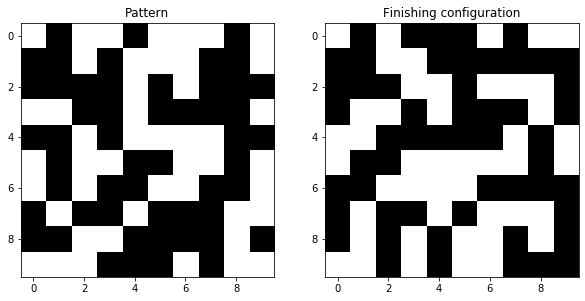

In [15]:
idx = 3
yi = corrupt_uniform(xi[idx], 0.35)

sys = not_MF_montecarlo(J,yi, 100, 100)

wrong_pixels = error_im(xi[idx],sys)
assigned_pattern = assign_pattern(xi,sys)

fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].set_title('Pattern')
ax[0].imshow(xi[idx].reshape(L,L), cmap='Greys')
ax[1].set_title('Finishing configuration')
ax[1].imshow(sys.reshape(L,L), cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

Uniform noise, we will analyse different probabilities $q$ with $\beta=25$, $R=[3,5]$ and $t=1000$.

In [8]:
xi = random_patterns(N,p)
prob = np.linspace(0,1,10)
err_rq_mean_c = []
err_rq_std_c = []
success_rq_c = []
for q in prob:
    J = R_coupling(xi,N,3)
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_uniform(xi[idx], q)
        sys = montecarlo(J, yi, 25, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_rq_mean_c.append( errors.mean() )
    err_rq_std_c.append( errors.std() )
    success_rq_c.append(correct)
    
err_rq1_mean_c = []
err_rq1_std_c = []
success_rq1_c = []
for q in prob:
    J = R_coupling(xi,N,5)
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_uniform(xi[idx], q)
        sys = montecarlo(J, yi, 25, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_rq1_mean_c.append( errors.mean() )
    err_rq1_std_c.append( errors.std() )
    success_rq1_c.append(correct)

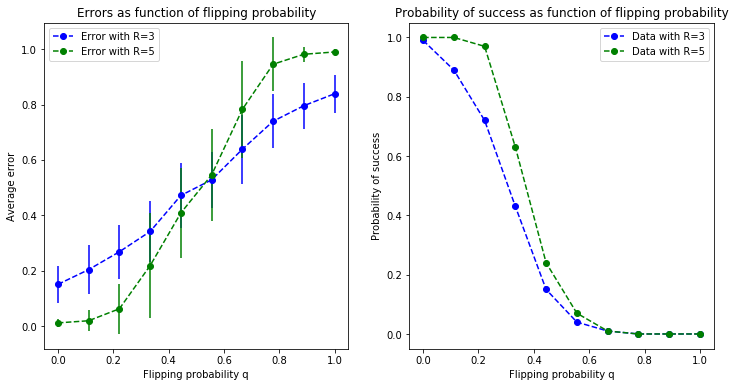

In [11]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of flipping probability')
ax[0].set_xlabel('Flipping probability q')
ax[0].set_ylabel('Average error')
ax[0].plot(prob, err_rq_mean_c, '--bo', label='Error with R=3')
ax[0].errorbar(prob,err_rq_mean_c, yerr=err_rq_std_c,ecolor='blue',fmt='none')
ax[0].plot(prob, err_rq1_mean_c, '--go', label='Error with R=5')
ax[0].errorbar(prob,err_rq1_mean_c, yerr=err_rq1_std_c,ecolor='green',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of flipping probability')
ax[1].set_xlabel('Flipping probability q')
ax[1].set_ylabel('Probability of success')
ax[1].plot(prob, success_rq_c, '--bo', label='Data with R=3')
ax[1].plot(prob, success_rq1_c, '--go', label='Data with R=5')
ax[1].legend()

There is nothing really interesting in these plots: the behaviour is similar to the one of the MF, but I stress again that this gives better results.

#### Gaussian noise

We start by $\beta=25$, $R=[3,5]$, $h=0.2$ and the different centroids

In [14]:
xi = random_patterns(N,p)
centroids = [np.array([0,0]), np.array([0,L-1]), np.array([L-1,0]), np.array([L-1,L-1]), np.array([L//2, L//2])]
err_rn_mean_c = []
err_rn_std_c = []
success_rn_c = []
for k in centroids:
    J = R_coupling(xi,N,5)
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_norm(xi[idx], k, 0.2)
        sys = montecarlo(J, yi, 25, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_rn_mean_c.append( errors.mean() )
    err_rn_std_c.append( errors.std() )
    success_rn_c.append(correct)
    

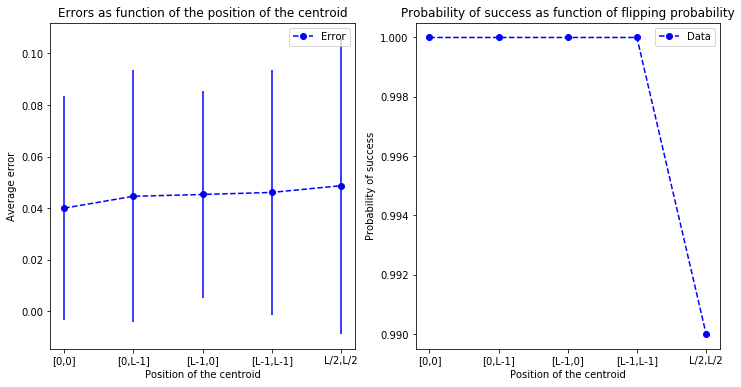

In [19]:
x = np.arange(5)
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of the position of the centroid')
ax[0].set_xlabel('Position of the centroid')
ax[0].set_xticks(x)
ax[0].set_xticklabels(['[0,0]','[0,L-1]','[L-1,0]','[L-1,L-1]','L/2,L/2'])
ax[0].set_ylabel('Average error')
ax[0].plot( x, err_rn_mean_c, '--bo', label='Error')
ax[0].errorbar(x, err_rn_mean_c, yerr=err_rn_std_c,ecolor='blue',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of flipping probability')
ax[1].set_xlabel('Position of the centroid')
ax[1].set_xticks(x)
ax[1].set_xticklabels(['[0,0]','[0,L-1]','[L-1,0]','[L-1,L-1]','L/2,L/2'])
ax[1].set_ylabel('Probability of success')
ax[1].plot( x, success_rn_c, '--bo', label='Data')
ax[1].legend()

We can see how the position of the centroid doesn't affect too much the error. The amazing thing is how well the algorithm is able to recover the correct pattern with gaussian noise. <br>
We will look now at how much probability the system can bear.

Same as above, but with centroids in a corner and in the middle but different heights of the gaussian.

In [6]:
xi = random_patterns(N,p)
heights = np.linspace(0,1,10)
err_rh_mean_c = []
err_rh_std_c = []
success_rh_c = []
for h in heights:
    J = R_coupling(xi,N,5)
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_norm(xi[idx], np.array([0,0]), h)
        sys = montecarlo(J, yi, 25, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_rh_mean_c.append( errors.mean() )
    err_rh_std_c.append( errors.std() )
    success_rh_c.append(correct)
    
err_rh1_mean_c = []
err_rh1_std_c = []
success_rh1_c = []
for h in heights:
    J = R_coupling(xi,N,5)
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_norm(xi[idx], np.array([L//2, L//2]), h)
        sys = montecarlo(J, yi, 25, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_rh1_mean_c.append( errors.mean() )
    err_rh1_std_c.append( errors.std() )
    success_rh1_c.append(correct)
    

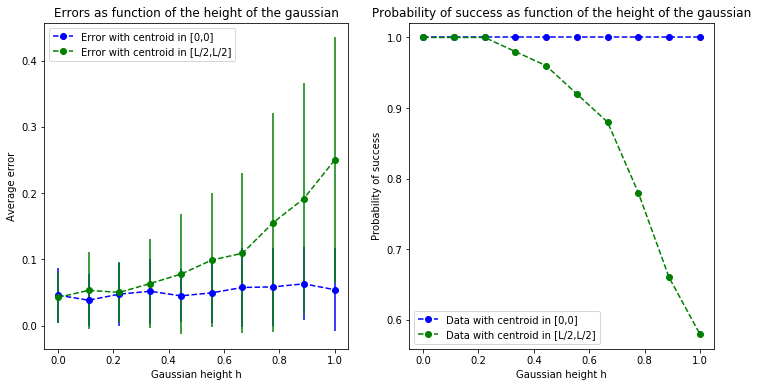

In [8]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of the height of the gaussian')
ax[0].set_xlabel('Gaussian height h')
ax[0].set_ylabel('Average error')
ax[0].plot(heights, err_rh_mean_c, '--bo', label='Error with centroid in [0,0]')
ax[0].errorbar(heights,err_rh_mean_c, yerr=err_rh_std_c,ecolor='blue',fmt='none')
ax[0].plot(heights, err_rh1_mean_c, '--go', label='Error with centroid in [L/2,L/2]')
ax[0].errorbar(heights,err_rh1_mean_c, yerr=err_rh1_std_c,ecolor='green',fmt='none')
ax[0].legend(loc='upper left')

ax[1].set_title('Probability of success as function of the height of the gaussian')
ax[1].set_xlabel('Gaussian height h')
ax[1].set_ylabel('Probability of success')
ax[1].plot(heights, success_rh_c, '--bo', label='Data with centroid in [0,0]')
ax[1].plot(heights, success_rh1_c, '--go', label='Data with centroid in [L/2,L/2]')
ax[1].legend()

Very very nice data for more than the MF one. Add some better comment but fine to me.

Notice that also flipping the center of the image with probability 1 there is still a 60% of probability of recognising the correct pattern.

## Time analisys

The aim of this section is to quantify the time implementation of the Montecarlo methods, both MF and not MF, in function of the size of the system N.

In [21]:
import time as tm

In [22]:
# I didn't run this cell but it is the very last thing to do
lenght = np.array([5, 10, 15, 20, 25, 28, 30])
size = lenght**2
time_n_mean = []
time_n_std = []
for n in size:
    xi = random_patterns(n,p)
    J =  MF_coupling(xi,n)
    time = []
    for j in range(100):
        start = tm.time()
        idx = np.random.randint(10)
        sys = not_MF_montecarlo(J, xi[idx], 25, 5, 1000)
        end = tm.time()
        time.append(end-start)
        
    time = np.array(time)
    time_n_mean.append( time.mean() )
    time_n_std.append( time.std() )
    
    
time_n1_mean = []
time_n1_std = []
for n in size:
    xi = random_patterns(n,p)
    J =  MF_coupling(xi,n)
    time = []
    for j in range(100):
        start = tm.time()
        idx = np.random.randint(10)
        sys = montecarlo(J, xi[idx], 25, 1000)
        end = tm.time()
        time.append(end-start)
        
    time = np.array(time)
    time_n1_mean.append( time.mean() )
    time_n1_std.append( time.std() )
    



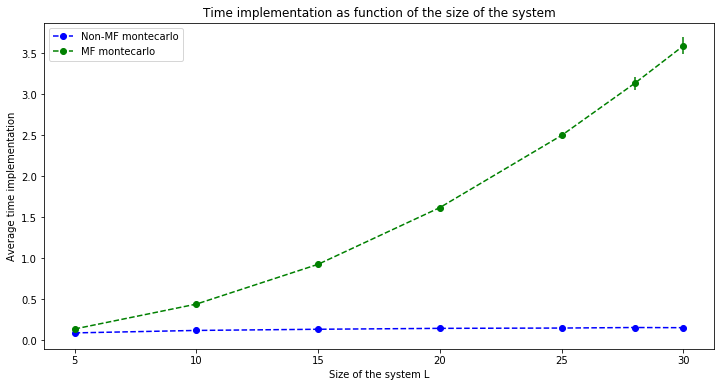

In [23]:
fig, ax = plt.subplots(figsize=(12,6))

ax.set_title('Time implementation as function of the size of the system')
ax.set_xlabel('Size of the system L')
ax.set_ylabel('Average time implementation')
ax.plot(lenght, time_n_mean, '--bo', label='Non-MF montecarlo')
ax.errorbar(lenght,time_n_mean, yerr=time_n_std,ecolor='blue',fmt='none')
ax.plot(lenght, time_n1_mean, '--go', label='MF montecarlo')
ax.errorbar(lenght,time_n1_mean, yerr= time_n1_std,ecolor='green',fmt='none')
ax.legend()



We can see the exponential behaviour in time of the MF montecarlo, and the strange behaviour of the non MF one.

# ---------------------------- The end -----------------------------

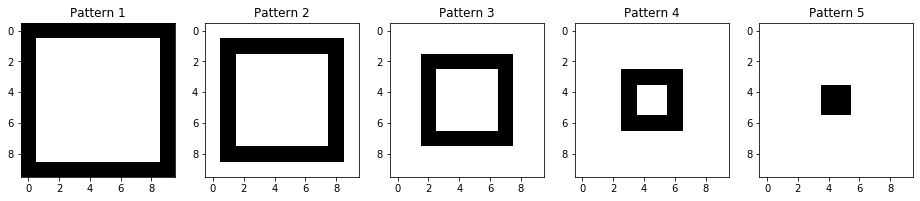

In [6]:
# frames
frames = [np.zeros(N)-1 for j in range((L+1)//2)]

for i in range((L+1)//2):
    for j in range(N):
        if j%L == i:
            frames[i][j] = 1
        if j%L == (L-i-1) :
            frames[i][j] = 1
        if j//L == i:
            frames[i][j] = 1
        if j//L == (L-i-1) :
            frames[i][j] = 1
    for k in range(i):
        for j in range(N):
            if j%L == k:
                frames[i][j] = -1
            if j%L == (L-k-1) :
                frames[i][j] = -1
            if j//L == k:
                frames[i][j] = -1
            if j//L == (L-k-1) :
                frames[i][j] = -1

fig, ax = plt.subplots(1, (L+1)//2 , figsize=(16,6))

for i in range((L+1)//2):
    ax[i].set_title('Pattern %i' %(i+1))
    ax[i].imshow(frames[i].reshape(L,L),cmap='Greys')
plt.show()    
                

-18.139999999999954
-18.139999999999954


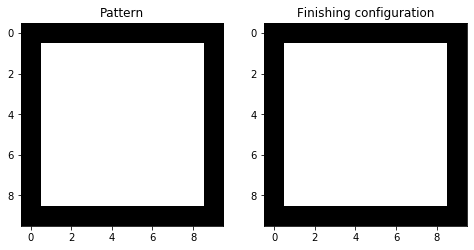

The error of the algorithm is 0.000000
The algorithm recognised the pattern 0 and the correct pattern is 0
-54.22000000000012
-54.22000000000012


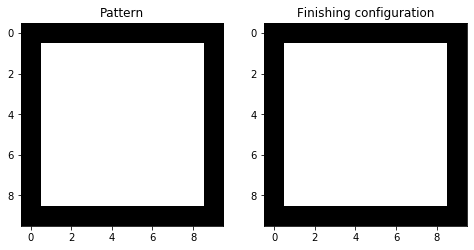

The error of the algorithm is 0.000000
The algorithm recognised the pattern 0 and the correct pattern is 0
-16.300000000000118
-16.300000000000118


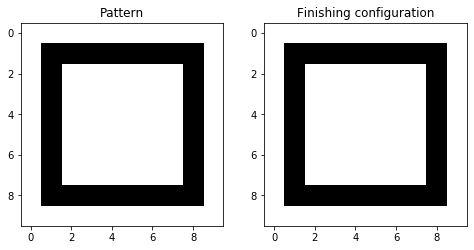

The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1
-59.97999999999947
-59.97999999999947


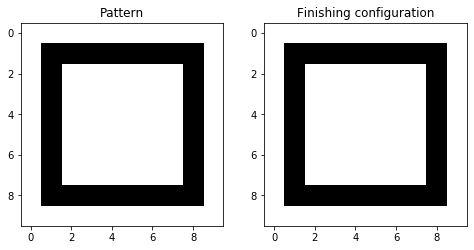

The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1
-16.380000000000123
-24.540000000000386


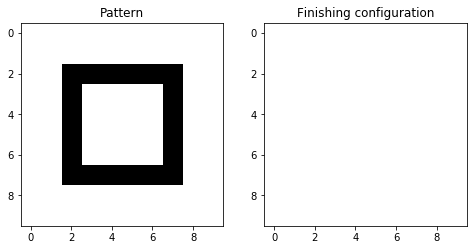

The error of the algorithm is 0.200000
The algorithm recognised the pattern 4 and the correct pattern is 2
-68.29999999999866
-68.29999999999866


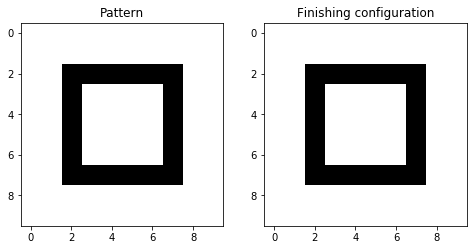

The error of the algorithm is 0.000000
The algorithm recognised the pattern 2 and the correct pattern is 2
-19.580000000000204
-24.540000000000386


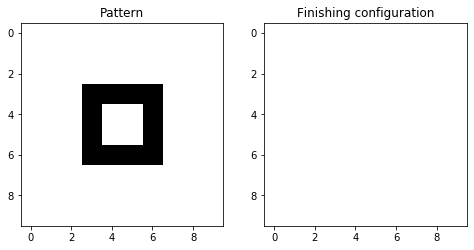

The error of the algorithm is 0.120000
The algorithm recognised the pattern 4 and the correct pattern is 3
-79.17999999999846
-100.30000000000202


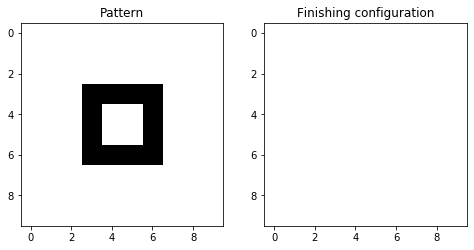

The error of the algorithm is 0.120000
The algorithm recognised the pattern 4 and the correct pattern is 3
-22.540000000000315
-24.540000000000386


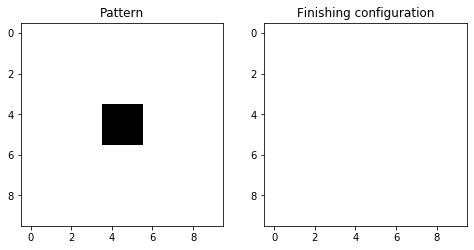

The error of the algorithm is 0.040000
The algorithm recognised the pattern 4 and the correct pattern is 4
-92.62000000000019
-100.30000000000202


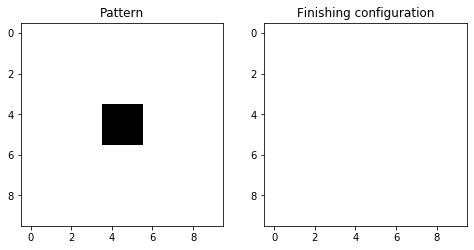

The error of the algorithm is 0.040000
The algorithm recognised the pattern 4 and the correct pattern is 4


In [8]:
frames = np.array(frames)
ind = np.arange(len(frames))

for idx in ind: 
    for MF in range(2):
        if MF: J = MF_coupling(frames,N)
        else: J = R_coupling(frames,N,R)
        supersys = np.zeros(N)
        for n in range(1):
            sys = deepcopy(frames[idx])
            print(H(J, sys))
            sys = montecarlo(J, sys, 25, 1000)
            print(H(J, sys))
            wrong_pixels = error_im(frames[idx],sys)
            assigned_pattern = assign_pattern(frames,sys)
            supersys += np.array(sys)
        fig, ax = plt.subplots(1,2, figsize = (8,5))
        ax[0].set_title('Pattern')
        ax[0].imshow(frames[idx].reshape(L,L), cmap='Greys')
        ax[1].set_title('Finishing configuration')
        ax[1].imshow(np.sign(supersys).reshape(L,L), cmap='Greys')
        plt.show()
        print('The error of the algorithm is %f' %(wrong_pixels))
        print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

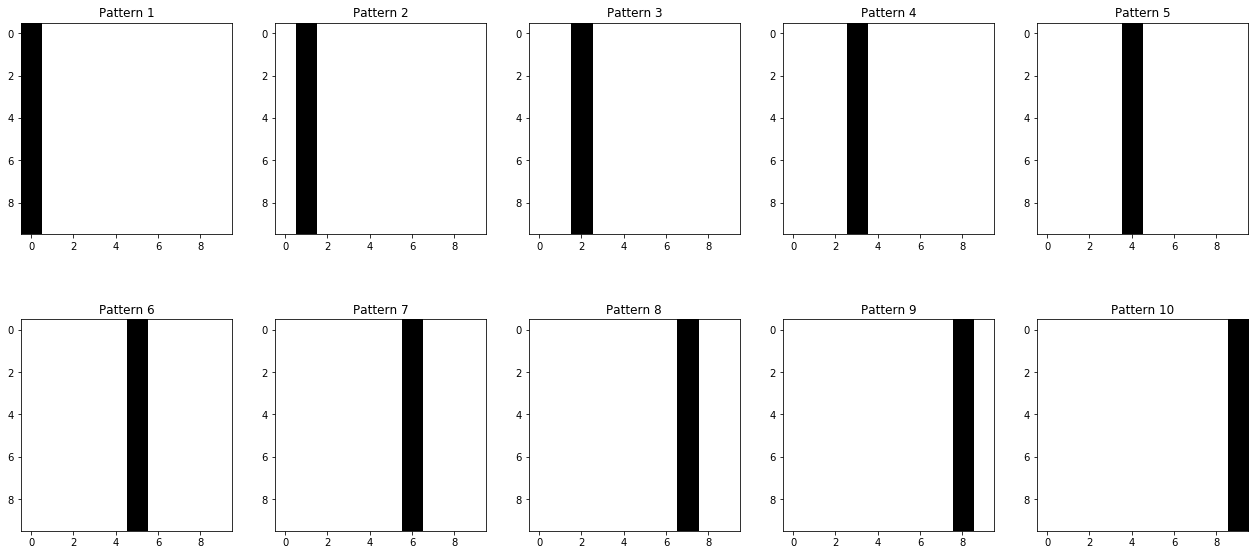

In [13]:
# straight verical lines patterns

patt = [np.zeros(N)-1 for j in range(L)]
for i in range(L):
    for j in range(L):
        patt[i][i+L*j]=1


fig, ax = plt.subplots(2, int(len(patt)/2), figsize=(22,10))

for i in range(int(len(patt)/2)):
    ax[0][i].set_title('Pattern %i' %(i+1))
    ax[0][i].imshow(patt[i].reshape(L,L),cmap='Greys')
    ax[1][i].set_title('Pattern %i' %(i+int(len(patt)/2)+1))
    ax[1][i].imshow(patt[i+int(len(patt)/2)].reshape(L,L),cmap='Greys')
plt.show()
    


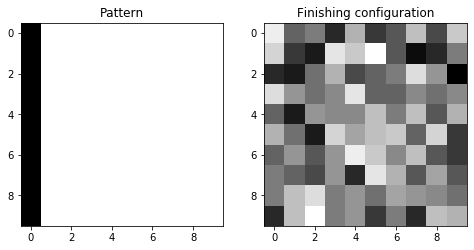

The error of the algorithm is 0.680000
The algorithm recognised the pattern 1 and the correct pattern is 0


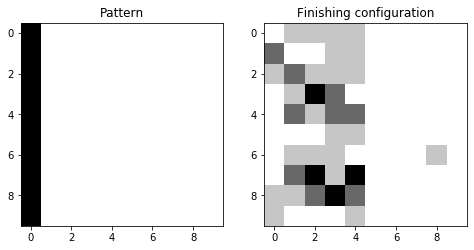

The error of the algorithm is 0.100000
The algorithm recognised the pattern 0 and the correct pattern is 0


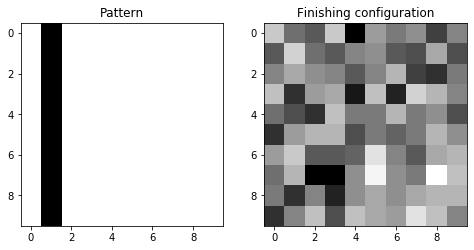

The error of the algorithm is 0.480000
The algorithm recognised the pattern 1 and the correct pattern is 1


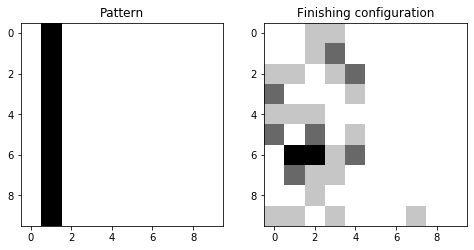

The error of the algorithm is 0.110000
The algorithm recognised the pattern 4 and the correct pattern is 1


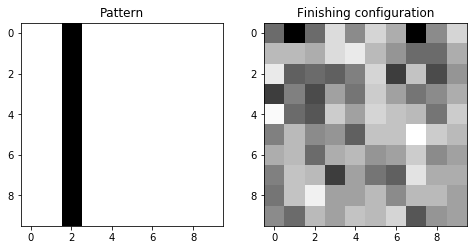

The error of the algorithm is 0.430000
The algorithm recognised the pattern 3 and the correct pattern is 2


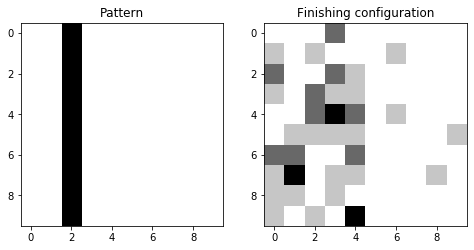

The error of the algorithm is 0.100000
The algorithm recognised the pattern 0 and the correct pattern is 2


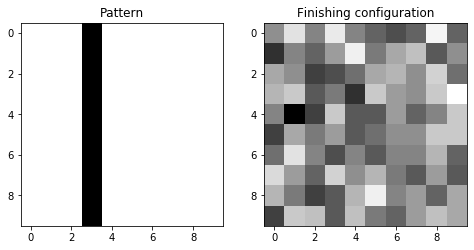

The error of the algorithm is 0.550000
The algorithm recognised the pattern 0 and the correct pattern is 3


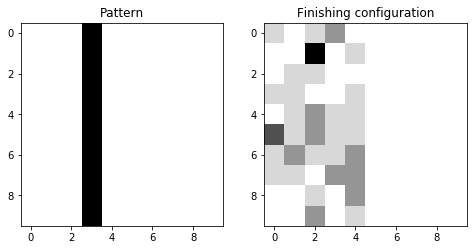

The error of the algorithm is 0.100000
The algorithm recognised the pattern 0 and the correct pattern is 3


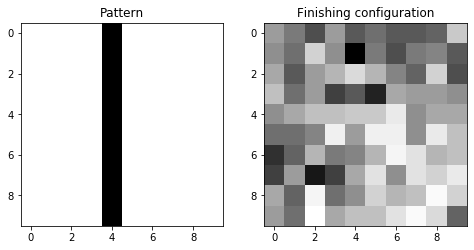

The error of the algorithm is 0.500000
The algorithm recognised the pattern 3 and the correct pattern is 4


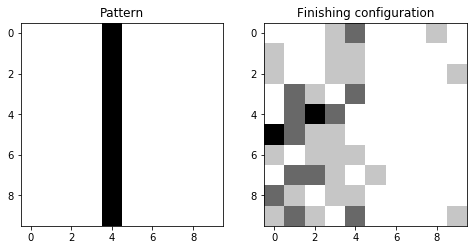

The error of the algorithm is 0.100000
The algorithm recognised the pattern 0 and the correct pattern is 4


In [22]:
# we try our algorithm to see if the patterns are distinguishable.
        
patt = np.array(patt[:5])
ind = np.arange(len(patt))

for idx in ind: 
    for MF in range(2):
        if MF: J = MF_coupling(patt,N)
        else: J = R_coupling(patt,N,R)
        supersys = np.zeros(N)
        for n in range(100):
            sys = deepcopy(patt[idx])
            sys = montecarlo(J, sys, 1, 1000)
            wrong_pixels = error_im(patt[idx],sys)
            assigned_pattern = assign_pattern(patt,sys)
            supersys += np.array(sys)
        fig, ax = plt.subplots(1,2, figsize = (8,5))
        ax[0].set_title('Pattern')
        ax[0].imshow(patt[idx].reshape(L,L), cmap='Greys')
        ax[1].set_title('Finishing configuration')
        ax[1].imshow((supersys/100).reshape(L,L), cmap='Greys')
        plt.show()
        print('The error of the algorithm is %f' %(wrong_pixels))
        print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

In [ ]:
l = 10
a = np.zeros(l*l)#.reshape(l,l)
for i in range(l*l):
    if i//l == 0: a[i]=1  # first row
    if i%l == 0: a[i]=1 # first column
    if i%l == l-1: a[i]=1 # last column
    if i//l ==l-1 : a[i]=1 # last row
a.reshape(l,l)

In [ ]:
k = 10
r = 2
a = np.zeros(l*l)
for i in range(k+1,k+r+1): # going right
    if k%l == l-1: break # right bound
    a[i]=1
    if i%l == l-1: break # last column bound
for i in range(k-1,k-r-1,-1): # going left
    if k%l == 0: break # left bound
    a[i]=1
    if i%l == 0: break # first column bound
for i in range(k+l,k+(r+1)*l,l): # going down
    if k//l == l-1: break # low bound
    a[i]=1
    if i//l ==l-1 : break # last row bound
for i in range(k-l, k-l*(r+1), -l): # going up
    if k//l == 0: break # up bound
    a[i]=1
    if i//l == 0: break  # first row bound
a.reshape(l,l)

In [ ]:
a = np.zeros(l*l)
k = l*(l-1)-2
r = 4
a[k]=5
for i in range(1,r):
    if k%l == l-1 or k//l == l-1: break # right low bound
    for j in range(1,r):
        if i==j==r-1: continue
        a[k+j+i*l] = 1 # right low
        if (k+j+i*l)%l == l-1 : 
            break # last column bound
    if (k+j+i*l)//l ==l-1 : break # last row bound
        
for i in range(1,r):
    if k%l == 0 or k//l == l-1: break # left low bound
    for j in range(1,r):
        if i==j==r-1: continue
        a[k-j+i*l] = 1 # left low
        if (k-j+i*l)%l == 0 : break #  first column bound
    if (k-j+i*l)//l ==l-1 : break # last row bound
        
for i in range(1,r):
    if k//l == 0 or k%l == l-1: break # up right bound
    for j in range(1,r):
        if i==j==r-1: continue
        a[k+j-i*l] = 1 # right up
        if (k+j-i*l)%l == l-1: break  # last column bound
    if (k+j-i*l)//l == 0: break # first row bound
        
for i in range(1,r):
    if k//l == 0 or k%l == 0 : break # up left bound
    for j in range(1,r):
        if i==j==r-1: continue
        a[k-j-i*l] = 1 # left up
        if (k-j-i*l)%l == l-1: break  #last column bound
    if (k-j-i*l)//l == 0 : break # first row bound
       
a.reshape(l,l)